In [198]:
import os

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import calendar

import datetime
plt.style.use('ggplot')

In [199]:
folder_path = '/Users/oliverastojanovic/Desktop/PSIML_2025/data/'
dataframes = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True).sort_values(by='Date')

## Exploratory data analysis

First we want to run a couple of checks if data is missing, is we have NaNs, etc.

In [200]:
data.head()

Date Source   Site ID  POC  Daily Mean PM2.5 Concentration  \
329990  01/01/2019    AQS  60690002    3                             2.3   
296724  01/01/2019    AQS  60010015    3                             2.7   
297076  01/01/2019    AQS  60070008    1                            13.5   
297237  01/01/2019    AQS  60070008    3                            12.5   
297970  01/01/2019    AQS  60074001    3                             5.4   

           Units  Daily AQI Value            Local Site Name  Daily Obs Count  \
329990  ug/m3 LC               13                  Hollister                1   
296724  ug/m3 LC               15      Pleasanton - Owens Ct                1   
297076  ug/m3 LC               59          Chico-East Avenue                1   
297237  ug/m3 LC               57          Chico-East Avenue                1   
297970  ug/m3 LC               30  TRAFFIC, RURAL PAVED ROAD                1   

        Percent Complete  ...  Method Code  \
329990             100.0  ...        170.0   
296724             100.0  ...        170.0   
297076             100.0  ...        145.0   
297237             100.0  ...        731.0   
297970             100.0  ...        731.0   

                                       Method Description  CBSA Code  \
329990               Met One BAM-1020 Mass Monitor w/VSCC    41940.0   
296724               Met One BAM-1020 Mass Monitor w/VSCC    41860.0   
297076  R & P Model 2025 PM-2.5 Sequential Air Sampler...    17020.0   
297237                       Met-One BAM-1020 W/PM2.5 SCC    17020.0   
297970                       Met-One BAM-1020 W/PM2.5 SCC    17020.0   

                                 CBSA Name  State FIPS Code       State  \
329990  San Jose-Sunnyvale-Santa Clara, CA                6  California   
296724   San Francisco-Oakland-Hayward, CA                6  California   
297076                           Chico, CA                6  California   
297237                           Chico, CA                6  California   
297970                           Chico, CA                6  California   

        County FIPS Code      County  Site Latitude Site Longitude  
329990                69  San Benito      36.843425    -121.362100  
296724                 1     Alameda      37.701222    -121.903019  
297076                 7       Butte      39.761680    -121.840470  
297237                 7       Butte      39.761680    -121.840470  
297970                 7       Butte      39.327563    -121.668811  

[5 rows x 22 columns]

In [201]:
data.describe()

Site ID            POC  Daily Mean PM2.5 Concentration  \
count  3.777970e+05  377797.000000                   377797.000000   
mean   6.056779e+07       3.293610                        9.025533   
std    2.945780e+05       3.887029                       11.977866   
min    6.001001e+07       1.000000                       -6.700000   
25%    6.031000e+07       1.000000                        4.100000   
50%    6.063101e+07       3.000000                        6.900000   
75%    6.075000e+07       3.000000                       10.800000   
max    6.113100e+07      26.000000                      824.100000   

       Daily AQI Value  Daily Obs Count  Percent Complete  AQS Parameter Code  \
count    377797.000000    377797.000000     377797.000000       377797.000000   
mean         40.347258         1.000222        100.022234        88192.692594   
std          26.455839         0.014909          1.490949          168.408057   
min           0.000000         1.000000        100.000000        88101.000000   
25%          23.000000         1.000000        100.000000        88101.000000   
50%          38.000000         1.000000        100.000000        88101.000000   
75%          54.000000         1.000000        100.000000        88101.000000   
max        1493.000000         2.000000        200.000000        88502.000000   

         Method Code      CBSA Code  State FIPS Code  County FIPS Code  \
count  357761.000000  346925.000000         377797.0     377797.000000   
mean      330.382196   35350.940232              6.0         56.634852   
std       250.379531    9865.278873              0.0         29.455437   
min       143.000000   12540.000000              6.0          1.000000   
25%       170.000000   31080.000000              6.0         31.000000   
50%       170.000000   40140.000000              6.0         63.000000   
75%       707.000000   41860.000000              6.0         75.000000   
max       810.000000   49700.000000              6.0        113.000000   

       Site Latitude  Site Longitude  
count  377797.000000   377797.000000  
mean       36.294985     -119.673694  
std         2.294345        2.016746  
min        32.552824     -124.203470  
25%        34.103740     -121.493110  
50%        36.489470     -119.706200  
75%        37.962069     -118.049167  
max        41.756130     -115.483070

It seems like we have some negative value in `Daily Mean PM2.5 Concentration` column, which shouldn't happen. Let's inspect those values.

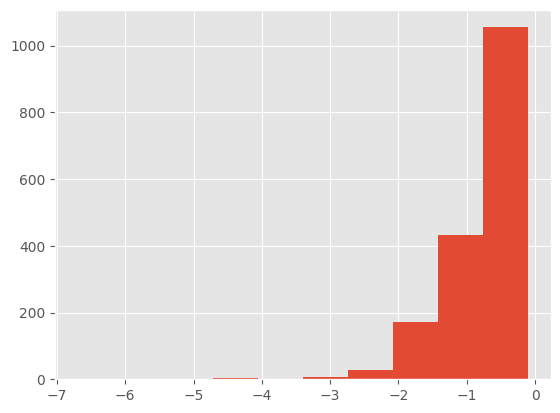

In [202]:
plt.hist(data[data["Daily Mean PM2.5 Concentration"]<0]["Daily Mean PM2.5 Concentration"])
plt.show()

Negative values usually come from equipment malfunction, and we will in this tutorial replace them with zeros.

In [203]:
data.loc[data["Daily Mean PM2.5 Concentration"] < 0, "Daily Mean PM2.5 Concentration"] = 0

In [204]:
data[data["Daily Mean PM2.5 Concentration"]<0]["Daily Mean PM2.5 Concentration"].sum() # the sum should we zero, we successfully replaced all negative values with zero

0.0

In [205]:
data.isnull().any() # there are some NaNs in the dataset, but we're lucky, we don't have any NaNs columns we will use

Date                              False
Source                            False
Site ID                           False
POC                               False
Daily Mean PM2.5 Concentration    False
Units                             False
Daily AQI Value                   False
Local Site Name                    True
Daily Obs Count                   False
Percent Complete                  False
AQS Parameter Code                False
AQS Parameter Description         False
Method Code                        True
Method Description                 True
CBSA Code                          True
CBSA Name                          True
State FIPS Code                   False
State                             False
County FIPS Code                  False
County                            False
Site Latitude                     False
Site Longitude                    False
dtype: bool

We want to fit a model on data from 2019 to 2024, and treat everything we have in 2025 as 'unseen data'. First, we need to ensure we have data for all counties during that period, as monitoring stations can sometimes go offline, be decommissioned, or fail to collect data for certain stretches of time.

In [206]:
# drop data for 2025
data['Date'] = pd.to_datetime(data['Date'])

rows_to_drop = data[data['Date'] > datetime.datetime(2024, 12, 31)].index

data = data.drop(rows_to_drop)

In [207]:
counties_list = data['County'].unique().tolist()

print("These counties have some data missing in the last 6 years:")

missing_counties = []
missing_dates_expanded = []
percentage_missing_list = [] 

# Define the expected date range for the last 6 years
start_date = "2019-01-01"
end_date = "2024-12-31"
expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')

for county in counties_list:
    county_data = data[data['County'] == county]
    
    # Ensure only unique dates are considered
    actual_dates = pd.to_datetime(county_data['Date']).drop_duplicates().sort_values()
    
    # Find missing dates by comparing expected and actual dates
    missing_dates = expected_dates.difference(actual_dates)
    
    if len(missing_dates) > 0: 
        missing_counties.append(county)
        percentage_missing = np.round((100 - len(actual_dates) / len(expected_dates) * 100), 2)
        percentage_missing_list.append({"County": county, "Percentage Missing": percentage_missing})
        
        for date in missing_dates:
            missing_dates_expanded.append({"County": county, "Missing Date": date})
        print(county, "has", percentage_missing, "% of data missing")

missing_dates_df = pd.DataFrame(missing_dates_expanded)
percentage_missing_df = pd.DataFrame(percentage_missing_list)
missing_dates_df = missing_dates_df.merge(percentage_missing_df, on="County", how="left")

These counties have some data missing in the last 6 years:
San Benito has 1.55 % of data missing
San Mateo has 5.34 % of data missing
Calaveras has 3.7 % of data missing
Colusa has 0.59 % of data missing
Contra Costa has 0.73 % of data missing
Glenn has 2.83 % of data missing
Imperial has 0.14 % of data missing
Yolo has 2.78 % of data missing
Ventura has 0.05 % of data missing
Tulare has 0.05 % of data missing
Tehama has 4.06 % of data missing
Sutter has 1.32 % of data missing
Sonoma has 8.62 % of data missing
Solano has 9.22 % of data missing
Siskiyou has 3.24 % of data missing
Santa Cruz has 0.09 % of data missing
Santa Clara has 0.18 % of data missing
Napa has 61.82 % of data missing
Orange has 0.5 % of data missing
San Francisco has 11.13 % of data missing
Mono has 4.97 % of data missing
Merced has 0.36 % of data missing
Mendocino has 0.32 % of data missing
Mariposa has 6.71 % of data missing
Marin has 1.55 % of data missing
Madera has 2.65 % of data missing
Del Norte has 16.83 % o

Most counties with missing dates have a very low percentage of missing data, which probably means there’s just an occasional missing date. In those cases, we can impute average values.

However, a few counties have a substantially higher proportion of missing dates, like Napa (61.82%) or Humboldt (53.6%). This likely indicates that monitoring stations went offline for an extended period. In such cases, it doesn’t make sense to impute average values. A common rule of thumb is that imputation is reasonable when less than 25% of the data is missing, although  this heavily depends on the context.

In our case, Shasta County has 25.55% missing data. That’s borderline, so we could reasonably go either way. I decided to keep it, since we're already excluding a few other counties.

In [208]:
counties_to_drop = percentage_missing_df[percentage_missing_df["Percentage Missing"] >= 26]["County"].tolist()

data = data[~data["County"].isin(counties_to_drop)].reset_index(drop=True)

remaining_counties = data["County"].unique()
print(f"Remaining counties: {len(remaining_counties)}")
print(f"Counties still in data: {remaining_counties}")

Remaining counties: 47
Counties still in data: ['San Benito' 'Alameda' 'Butte' 'San Mateo' 'Calaveras' 'Colusa'
 'San Luis Obispo' 'Contra Costa' 'Fresno' 'Glenn' 'Imperial' 'Inyo'
 'San Joaquin' 'Kern' 'Santa Barbara' 'San Bernardino' 'Yolo' 'Ventura'
 'Tulare' 'Tehama' 'Sutter' 'Stanislaus' 'Sonoma' 'Solano' 'Siskiyou'
 'Santa Cruz' 'Santa Clara' 'Kings' 'San Diego' 'Orange' 'Placer'
 'Riverside' 'Sacramento' 'Monterey' 'Los Angeles' 'San Francisco' 'Mono'
 'Merced' 'Mendocino' 'Mariposa' 'Marin' 'Madera' 'Del Norte' 'Trinity'
 'Nevada' 'Plumas' 'Shasta']


### Impute data

In [209]:
# Filter out counties to drop
missing_dates_df = missing_dates_df[~missing_dates_df['County'].isin(counties_to_drop)].reset_index(drop=True)

new_rows = []

for county in missing_dates_df['County'].unique():
    county_missing_dates = missing_dates_df[missing_dates_df['County'] == county]['Missing Date']
    
    # Get a sample row for the county to copy other column values
    sample_row = data[data['County'] == county].iloc[0].to_dict()
    
    # Calculate mean values for specific columns
    mean_values = data[data['County'] == county][['Daily Mean PM2.5 Concentration', 'Daily AQI Value', 'Daily Obs Count']].mean()

    # Create new rows for missing dates
    for missing_date in county_missing_dates:
        new_row = sample_row.copy() 
        new_row['Date'] = missing_date 
        new_row.update(mean_values.to_dict())
        new_rows.append(new_row)

data = pd.concat([data, pd.DataFrame(new_rows)], ignore_index=True)
data = data.sort_values(by=['County', 'Date']).reset_index(drop=True)

In [210]:
# Check if there are any missing dates in the entire data DataFrame
start_date = "2019-01-01"
end_date = "2024-12-31"
expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')

actual_dates = pd.to_datetime(data['Date']).drop_duplicates().sort_values()
missing_dates = expected_dates.difference(actual_dates)

if len(missing_dates) > 0:
    print(f"The dataset still has {len(missing_dates)} missing dates.")
else:
    print("The dataset has no missing dates.")

The dataset has no missing dates.


In [211]:
len(data['County'].unique())

47

### Time-series of daily PM2.5 concentration

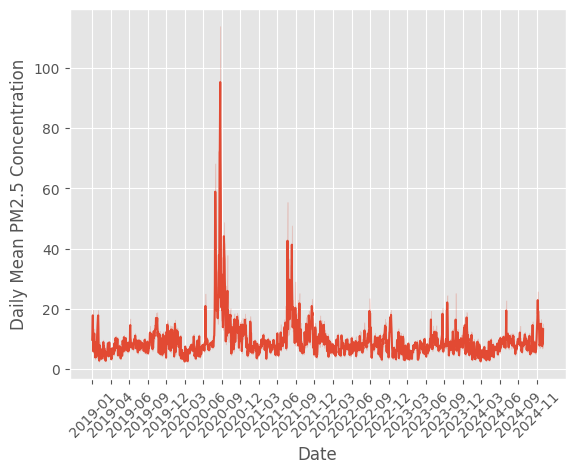

In [212]:
sns.lineplot(data=data, x="Date", y="Daily Mean PM2.5 Concentration")

tick_step = 90
unique_dates = pd.Series(data['Date'].unique()) 
plt.xticks(ticks=unique_dates[::tick_step], 
           labels=unique_dates[::tick_step].dt.strftime('%Y-%m'), 
           rotation=45)
plt.show()

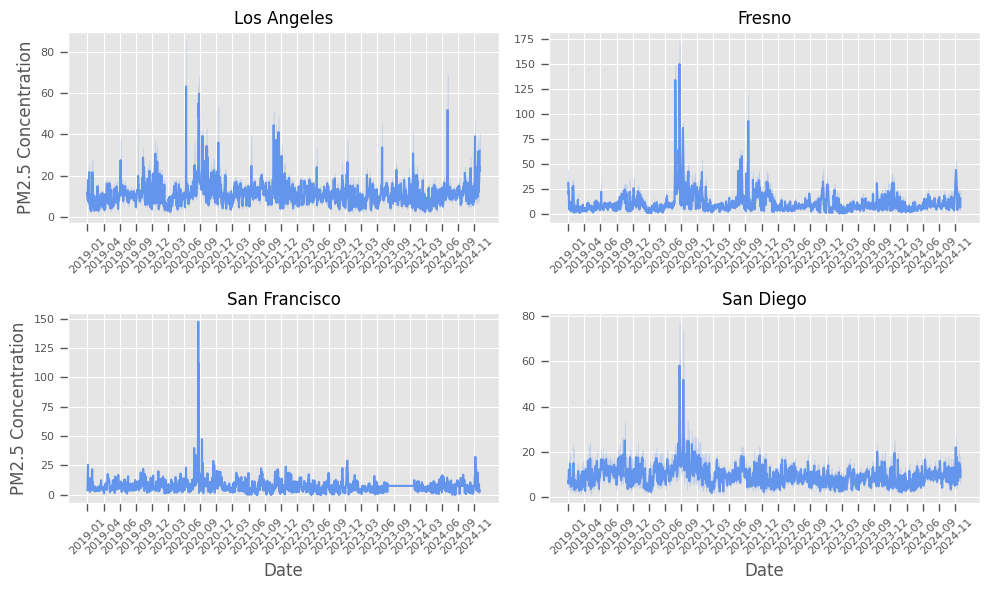

In [213]:
counties = ['Los Angeles', 'Fresno', 'San Francisco', 'San Diego']

fig, axes = plt.subplots(int(len(counties)/2), int(len(counties)/2), figsize=(10, 6))

axes = axes.flatten()

for i, (ax, county) in enumerate(zip(axes, counties)):
    county_data = data[data['County'] == county]
    sns.lineplot(data=county_data, x='Date', y='Daily Mean PM2.5 Concentration', ax=ax, color='cornflowerblue')

    x_label = "Date" if i == 2 or i == 3 else ''
    y_label = "PM2.5 Concentration" if i == 0 or i == 2 else ''

    ax.set_xlabel(x_label, fontsize=12 if x_label else None)
    ax.set_ylabel(y_label, fontsize=12 if y_label else None)
    
    ax.set_title(f'{county}', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=8, length=6, width=1)
    ax.tick_params(axis='x', rotation=45)

    tick_step = 90 
    unique_dates = pd.Series(data['Date'].unique())  # Convert to Pandas Series
    ax.set_xticks(ticks=unique_dates[::tick_step], 
           labels=unique_dates[::tick_step].dt.strftime('%Y-%m'), 
           rotation=45)
    
plt.tight_layout()
plt.show()

### Does data have seasonality?

Before developing a model, we should check whether the data exhibits any seasonal patterns.

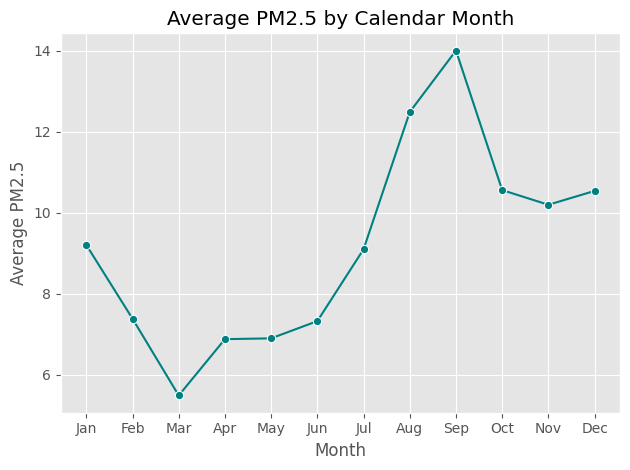

In [214]:
data["month_name"] = data["Date"].dt.strftime('%b')
data["month_num"] = data["Date"].dt.month  # for correct ordering

# Group by month number to preserve order
monthly_seasonal_avg = data.groupby("month_num")["Daily Mean PM2.5 Concentration"].mean().reset_index()

monthly_seasonal_avg["month_name"] = monthly_seasonal_avg["month_num"].apply(lambda x: calendar.month_abbr[x]) 

sns.lineplot(x='month_name', y='Daily Mean PM2.5 Concentration', data=monthly_seasonal_avg, marker='o', color='teal')
plt.title("Average PM2.5 by Calendar Month")
plt.xlabel("Month")
plt.ylabel("Average PM2.5")
plt.tight_layout()
plt.show()


The box plots show higher median exceedance days and greater variability toward the end of the year and in January. Additionally, there are more outliers during these months, indicating occasional spikes in PM2.5 exceedance. 

This pattern likely reflects a combination of factors: 

* wildfire activity in late summer and fall, driven in part by strong dry winds such as the __[Santa Ana winds](https://en.wikipedia.org/wiki/Santa_Ana_winds)__ in Southern California and __[Diablo winds](https://en.wikipedia.org/wiki/Diablo_wind)__ in Northern California, which rapidly spread fires and worsen air quality

* winter pollution events like __[temperature inversions](https://www.eea.europa.eu/en/analysis/maps-and-charts/temperature-inversion-traps-pollution-at)__ and residential heating contribute to elevated PM2.5 levels in the colder months.

## Plot distribution of monthly exceedance

In Bayesian inference, we start with priors. In the case of PM2.5 incidence and exceedance days, we know that concentrations are generally expected to be low—most days should fall below the 35 µg/m³ threshold. If they didn’t, it would indicate a serious public health crisis.

We also know that PM2.5 values can't be negative, and based on the nature of the data, we should expect a positively skewed distribution with a light tail. The plot below will help our choice of priors. 

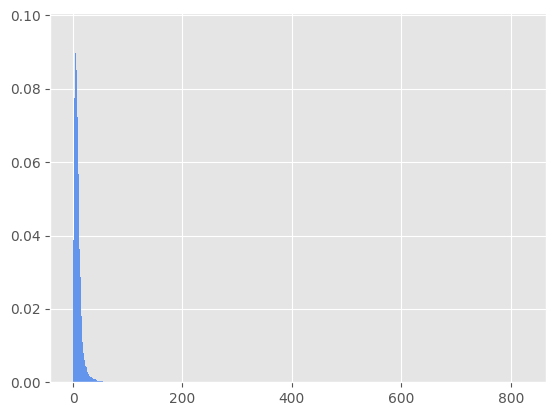

In [215]:
plt.hist(data['Daily Mean PM2.5 Concentration'], bins=1000, color='cornflowerblue', density=True)
plt.show()

We plot this to examine how the values are distributed. As expected, many data points are close to zero, with most monthly exceedance counts falling between 0 and 5. A few exceedance values reach 25 or higher, likely corresponding to extended wildfire events.

As expected, there are no negative values.

This tells us that classical linear regression isn’t suitable here. Linear regression assumes a Normally distributed outcome, which includes the possibility of negative values.

Instead, we need a distribution that only allows positive values and isn't heavy-tailed, since the majority of our data is concentrated at the lower end. Since we’re working with count data, two appropriate distributions to consider are Poisson and Negative Binomial.

## Fitting a Bayesian hierarchical model

### Bayesian hierarchical models

__[Bayesian hierarchical models](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling)__ are a class of statistical models that involve multiple levels of parameters, allowing for the modeling of complex, structured data. They are particularly useful when data is organized in groups or layers, such as nested or repeated measurements, or when modeling different regions that share common characteristics. In these models, parameters at one level of the hierarchy depend on parameters at a higher level, facilitating the sharing of information across different groups. In our case, this means capturing similar seasonality patterns or trends across four regions. This approach leads to more accurate and robust inferences, especially when some groups, have limited data.

#### Model Assumptions and Overview
In this analysis, I make the following key assumptions about the data and the model:

1. **Distribution of Monthly Exceedance Days:**
We assume that the monthly exceedance days follow a __[Negative Binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution)__. This is appropriate because data represents nonnegative count values, and the Negative Binomial distribution is well-suited for modeling count data with overdispersion (i.e., when the variance exceeds the mean).

    An alternative would have been a __[Poisson distrubution](https://en.wikipedia.org/wiki/Poisson_distribution)__, which is also used for count data. However, the Poisson model assumes that the mean and variance are equal, which can be too restrictive in real-world data, especially in environmental or epidemiological contexts where variability tends to be higher.

2. **Parameterization of the Negative Binomial Distribution:**
The Negative Binomial distribution gives us more flexibility because it has two parameters: one controlling the mean and another controlling the dispersion (an overdispersion parameter, α.). This extra parameter allows the variance to exceed the mean, making it a more realistic choice for overdispersed data. In contrast, the Poisson distribution has only a single parameter, λ, which determines both the mean and the variance, so it cannot account for overdispersion.

3. **Data Characteristics:**
Our dataset is limited in size. Although each county has its own unique characteristics, there are commonalities between them that we can use for modeling.

4. **Bayesian Hierarchical Models:**

* **Combining Data:** Bayesian hierarchical models are used to combine data from different counties. This approach allows us to capture both shared patterns and individual variations among them.

* **Group-Specific Variations:** The hierarchical structure of the model enables us to account for group-specific variations while still pooling information across counties.

#### Markov Chain Monte Carlo sampling

__[Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)__ sampling is a set of algorithms used to approximate the posterior distribution of a model's parameters when direct computation is intractable, which is often the case with Bayesian hierarchical models. MCMC generates samples from this distribution, which can then be used to estimate summary statistics or make predictions.

### Prepare data

In [216]:
# Sort the DataFrame by 'county' and 'year_month'and extract the first date for each county
# We know that first date everywhere should be 2019-01-01, 
# but let's do it automatically just in case one county has no data for that month 
data = data.sort_values(by=['County', 'Date'])

first_dates = data.groupby('County')['Date'].first().reset_index()
first_dates.rename(columns={'Date': 'first_date'}, inplace=True)  # Rename the column to 'first_date'

data = data.merge(first_dates, on='County', how='left')

In [217]:
# compute the total time since beginning of time-serials (in years)
# This will be later used to calculate seasonality and trend

data["time_passed_total"] = (
    data['Date'].apply(datetime.datetime.toordinal)
    -data['first_date'].apply(datetime.datetime.toordinal)
)/365.0

### Model 1: County-hierarchy

In [218]:
data_copy = data.copy()

data_copy['year_month'] = data_copy['Date'].dt.strftime('%Y-%m')

monthly_avg = data_copy.groupby(['County', 'year_month'])['Daily Mean PM2.5 Concentration'].mean().reset_index()

monthly_avg.rename(columns={'Daily Mean PM2.5 Concentration': 'Monthly Avg PM2.5'}, inplace=True)

first_dates = monthly_avg.groupby('County')['year_month'].first().reset_index()
first_dates.rename(columns={'year_month': 'first_date'}, inplace=True)

monthly_avg = monthly_avg.merge(first_dates, on='County', how='left')

monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'], format='%Y-%m')
monthly_avg['first_date'] = pd.to_datetime(monthly_avg['first_date'], format='%Y-%m')

# Calculate time passed in years since county's first month (for trend)
monthly_avg["time_passed_total"] = (
    monthly_avg['year_month'].apply(datetime.datetime.toordinal)
    - monthly_avg['first_date'].apply(datetime.datetime.toordinal)
) / 365.0


monthly_avg['month'] = monthly_avg['year_month'].dt.month

# Normalize month to [0,1) for seasonality
monthly_avg['month_fraction'] = (monthly_avg['month'] - 1) / 12.0

monthly_avg


County year_month  Monthly Avg PM2.5 first_date  time_passed_total  \
0     Alameda 2019-01-01           9.066667 2019-01-01           0.000000   
1     Alameda 2019-02-01           4.255952 2019-01-01           0.084932   
2     Alameda 2019-03-01           5.255978 2019-01-01           0.161644   
3     Alameda 2019-04-01           7.265294 2019-01-01           0.246575   
4     Alameda 2019-05-01           6.307065 2019-01-01           0.328767   
...       ...        ...                ...        ...                ...   
3379     Yolo 2024-08-01           7.184706 2019-01-01           5.586301   
3380     Yolo 2024-09-01           6.325556 2019-01-01           5.671233   
3381     Yolo 2024-10-01           7.594624 2019-01-01           5.753425   
3382     Yolo 2024-11-01           9.102222 2019-01-01           5.838356   
3383     Yolo 2024-12-01          13.923864 2019-01-01           5.920548   

      month  month_fraction  
0         1        0.000000  
1         2        0.083333  
2         3        0.166667  
3         4        0.250000  
4         5        0.333333  
...     ...             ...  
3379      8        0.583333  
3380      9        0.666667  
3381     10        0.750000  
3382     11        0.833333  
3383     12        0.916667  

[3384 rows x 7 columns]

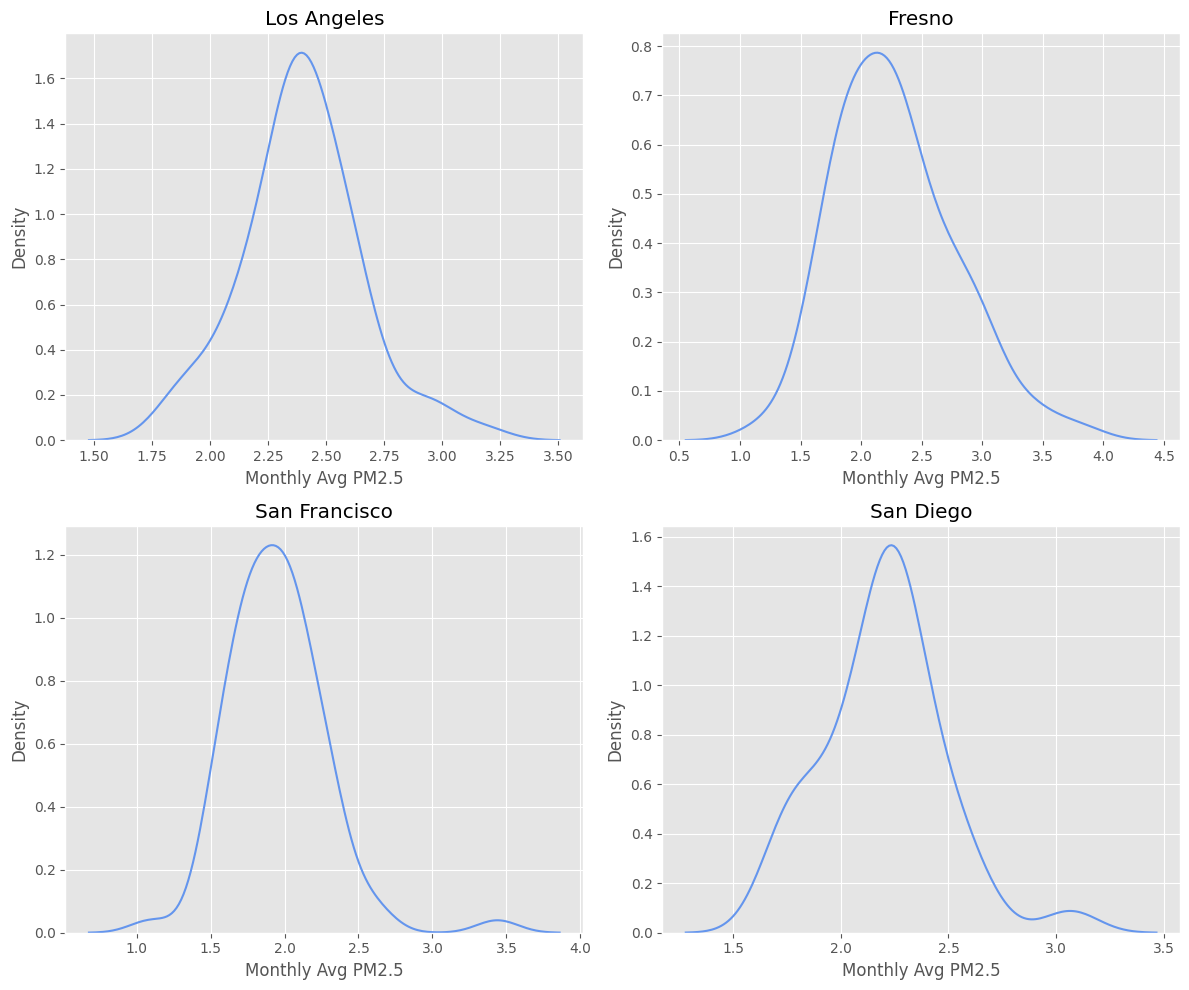

In [219]:
counties = ['Los Angeles', 'Fresno', 'San Francisco', 'San Diego']


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, county in zip(axes.flatten(), counties):
    county_data = monthly_avg[monthly_avg['County'] == county]
    sns.kdeplot(np.log(county_data['Monthly Avg PM2.5']), color='cornflowerblue', ax=ax)
    ax.set_title(county)
    ax.set_xlabel('Monthly Avg PM2.5')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

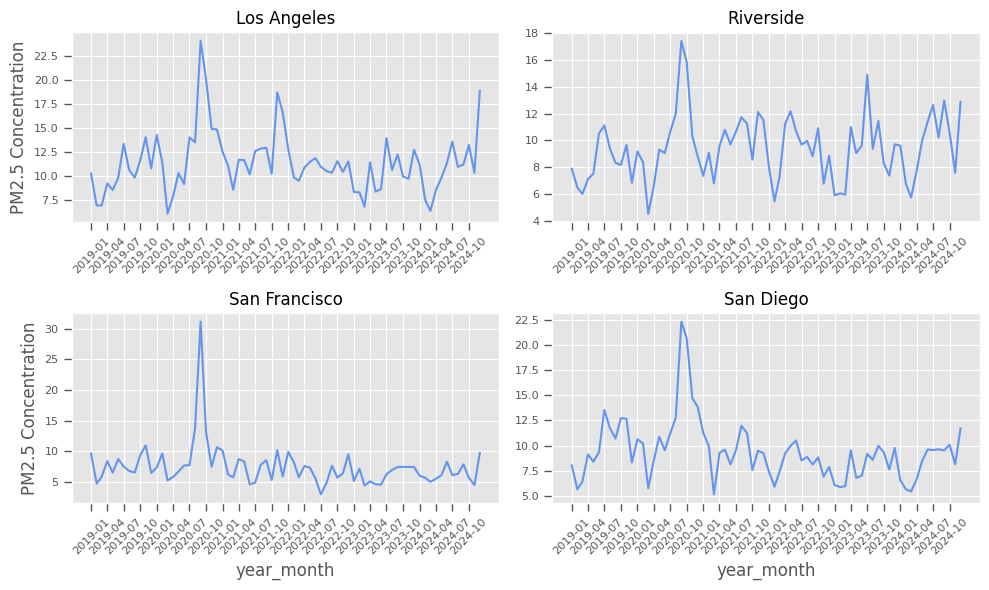

In [220]:
counties = ['Los Angeles', 'Riverside', 'San Francisco', 'San Diego']

fig, axes = plt.subplots(int(len(counties)/2), int(len(counties)/2), figsize=(10, 6))

axes = axes.flatten()

for i, (ax, county) in enumerate(zip(axes, counties)):
    county_data = monthly_avg[monthly_avg['County'] == county]
    sns.lineplot(data=county_data, x='year_month', y='Monthly Avg PM2.5', ax=ax, color='cornflowerblue')

    x_label = "year_month" if i == 2 or i == 3 else ''
    y_label = "PM2.5 Concentration" if i == 0 or i == 2 else ''

    ax.set_xlabel(x_label, fontsize=12 if x_label else None)
    ax.set_ylabel(y_label, fontsize=12 if y_label else None)
    
    ax.set_title(f'{county}', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=8, length=6, width=1)
    ax.tick_params(axis='x', rotation=45)

    tick_step = 3
    unique_dates = pd.Series(monthly_avg['year_month'].unique())  # Convert to Pandas Series
    ax.set_xticks(ticks=unique_dates[::tick_step], 
           labels=unique_dates[::tick_step].dt.strftime('%Y-%m'), 
           rotation=45)
    
plt.tight_layout()
plt.show()

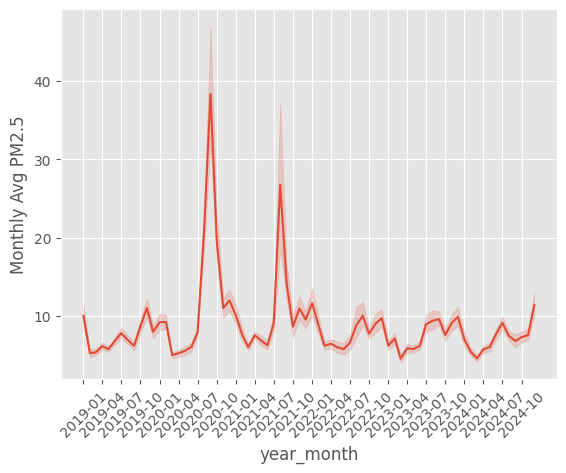

In [221]:
sns.lineplot(data=monthly_avg, x="year_month", y='Monthly Avg PM2.5')

tick_step = 3
unique_dates = pd.Series(monthly_avg['year_month'].unique()) 
plt.xticks(ticks=unique_dates[::tick_step], 
           labels=unique_dates[::tick_step].dt.strftime('%Y-%m'), 
           rotation=45)
plt.show()

<Axes: xlabel='Monthly Avg PM2.5', ylabel='Density'>

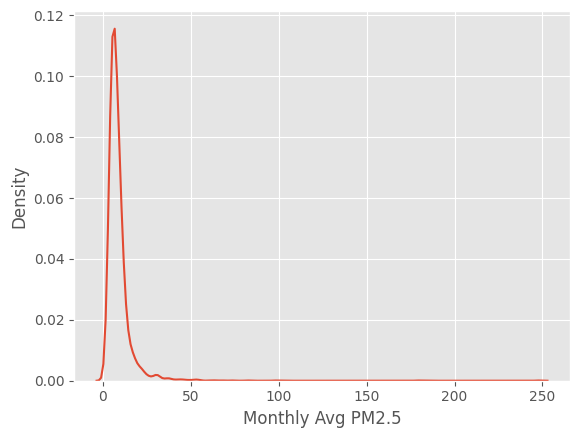

In [222]:
sns.kdeplot(monthly_avg["Monthly Avg PM2.5"])

(array([ 525., 1474.,  809.,  274.,  114.,   62.,   38.,   16.,   23.,
          10.]),
 array([ 1.1975,  4.561 ,  7.9245, 11.288 , 14.6515, 18.015 , 21.3785,
        24.742 , 28.1055, 31.469 , 34.8325]),
 <BarContainer object of 10 artists>)

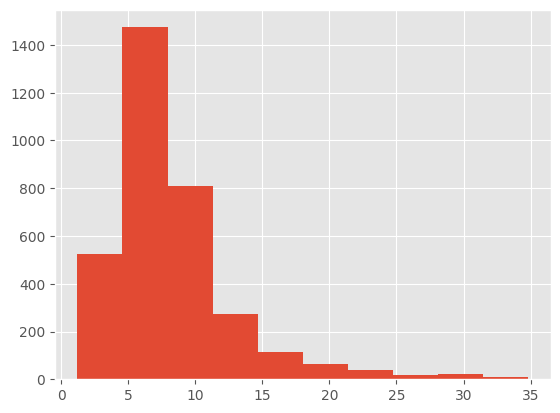

In [223]:
plt.hist(monthly_avg[monthly_avg["Monthly Avg PM2.5"] <= 35]["Monthly Avg PM2.5"])

<Axes: xlabel='Monthly Avg PM2.5', ylabel='Density'>

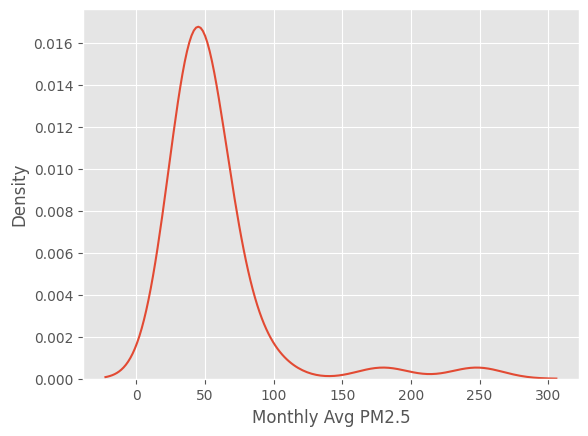

In [224]:
sns.kdeplot(monthly_avg[monthly_avg["Monthly Avg PM2.5"] > 35]["Monthly Avg PM2.5"])

In [225]:
monthly_avg['county_id']

KeyError: 'county_id'

In [147]:
county_avg[monthly_avg['county_id']]

/var/folders/df/cxyt_gv55w9g14vxfcmg87zh0000gn/T/ipykernel_22426/3551045095.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  county_avg[monthly_avg['county_id']]


County
Alameda    8.137888
Alameda    8.137888
Alameda    8.137888
Alameda    8.137888
Alameda    8.137888
             ...   
Yolo       7.898079
Yolo       7.898079
Yolo       7.898079
Yolo       7.898079
Yolo       7.898079
Name: Monthly Avg PM2.5, Length: 3384, dtype: float64

<Axes: xlabel='year_month', ylabel='Monthly Avg PM2.5'>

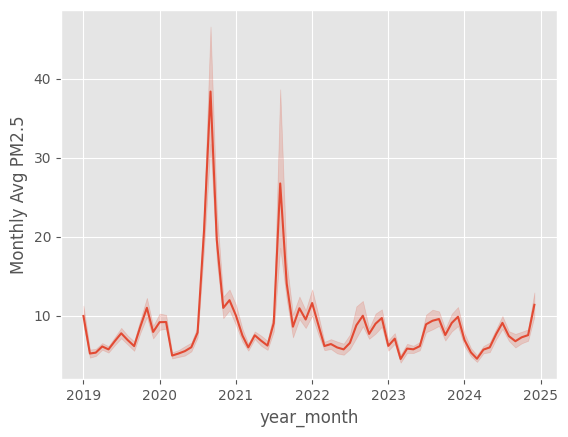

In [163]:
sns.lineplot(data=monthly_avg, x='year_month', y="Monthly Avg PM2.5")

<Axes: xlabel='year_month', ylabel='is_extreme'>

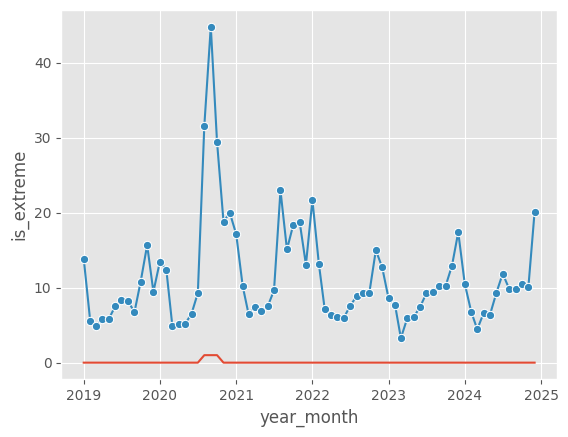

In [177]:
sns.lineplot(data=monthly_avg[monthly_avg["County"]=="Fresno"], x='year_month', y="is_extreme")
sns.lineplot(data=monthly_avg[monthly_avg["County"]=="Fresno"], x='year_month', y="Monthly Avg PM2.5", marker="o")

In [226]:
monthly_avg.shape[0]

3384

In [258]:
monthly_avg['county_id'] = monthly_avg['County'].astype('category').cat.codes
n_counties = monthly_avg['county_id'].nunique()

#county_avg = monthly_avg.groupby('County')['Monthly Avg PM2.5'].mean()
#county_std = monthly_avg.groupby('County')['Monthly Avg PM2.5'].std()

#monthly_avg['is_extreme'] = np.abs(monthly_avg['Monthly Avg PM2.5'].values - county_avg.iloc[monthly_avg['county_id']].values) > 2*county_std.iloc[monthly_avg['county_id']].values

with pm.Model() as model:

    # priors for seasonality
    sine = pm.math.sin(2 * np.pi * (monthly_avg["month_fraction"].values % 1))
    cosine = pm.math.cos(2 * np.pi * (monthly_avg["month_fraction"].values % 1))

    w_s = pm.Normal("w_s", mu=0, sigma=1)
    w_c = pm.Normal("w_c", mu=0, sigma=1)

    #seasonality_mu = pm.Normal("seasonality_mu", mu=0, sigma=2)  # wide prior on mean
    #seasonality_offset = pm.Normal("seasonality_offset", mu=0, sigma=0.5, shape=n_counties)
    #seasonality_slope = pm.math.abs(seasonality_mu + seasonality_offset)
    
    #seasonality = seasonality_slope[monthly_avg['county_id']] * (sine * w_s + cosine * w_c)
    seasonality = sine * w_s + cosine * w_c

    # priors for intercept
    intercept_mu = pm.Normal("intercept_mu", mu=0, sigma=5)  # wide prior on mean
    
    intercept_offset = pm.Normal("intercept_offset", mu=0, sigma=1, shape=n_counties)
    intercept_raw = intercept_mu +  intercept_offset
    
    intercept = intercept_raw[monthly_avg['county_id']]

    # priors for trend
    #mu_trend = pm.Normal("mu_trend", mu=0, sigma=5)  # wide prior on mean

    #trend_offset = pm.Normal("trend_offset", mu=0, sigma=1, shape=n_counties)
    #weight_trend = mu_trend + trend_offset
    #
    #trend = weight_trend[monthly_avg['county_id']] * monthly_avg["time_passed_total"].values

    # priors for cutoff
    #mu_cutoff = pm.Normal("mu_cutoff", mu=35, sigma=5)
    #cutoff_offset = pm.Normal("cutoff_offset", mu=0, sigma=5, shape=n_counties)
    #cutoff = mu_cutoff + cutoff_offset[monthly_avg['county_id']]

    # create a binary variable for extreme values
    p_is_extreme = pm.Beta("p_is_extreme", alpha=1, beta=50)
    is_extreme = pm.Bernoulli("is_extreme", p_is_extreme, shape=monthly_avg.shape[0])  
    #is_extreme = monthly_avg['Monthly Avg PM2.5'].values > cutoff

    # calculate the expected value of the response variable
    mu_base = intercept + seasonality #+ trend
    mu_extreme = pm.Normal("mu_extreme", mu=5, sigma=5)
    #mu = mu_extreme*is_extreme + mu_base
    mu = pm.math.switch(is_extreme, mu_extreme, mu_base)

    sigma_base = pm.HalfCauchy("sigma_base", beta=1)  # prior for the standard deviation
    sigma_extreme = pm.HalfCauchy("sigma_extreme", beta=1)  # prior for the standard deviation
    #sigma = pm.Deterministic("sigma", is_extreme * sigma_extreme + sigma_base)
    sigma = pm.math.switch(is_extreme, sigma_extreme, sigma_base)


    # likelihood
    Y = pm.LogNormal("Y", 
                    mu=mu, 
                    sigma=sigma, 
                    observed=monthly_avg['Monthly Avg PM2.5'])

    trace = pm.sample(1000, tune=500, chains=4, cores=4, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [w_s, w_c, intercept_mu, intercept_offset, p_is_extreme, mu_extreme, sigma_base, sigma_extreme]
>BinaryGibbsMetropolis: [is_extreme]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 329 seconds.
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [228]:
model

             w_s ~ Normal(0, 1)
             w_c ~ Normal(0, 1)
    intercept_mu ~ Normal(0, 5)
intercept_offset ~ Normal(0, 1)
        mu_trend ~ Normal(0, 5)
    trend_offset ~ Normal(0, 1)
      is_extreme ~ Bernoulli(0.01)
      mu_extreme ~ Normal(5, 5)
      sigma_base ~ HalfCauchy(0, 1)
   sigma_extreme ~ HalfCauchy(0, 1)
               Y ~ LogNormal(f(is_extreme, mu_extreme, trend_offset, intercept_offset, mu_trend, w_c, w_s, intercept_mu), f(is_extreme, sigma_extreme, sigma_base))

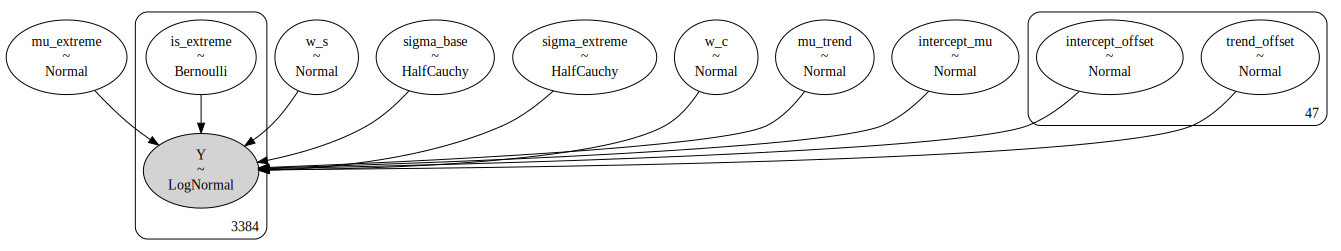

In [229]:
pm.model_to_graphviz(model)

### Convergence checks

The R-hat statistic, also known as the __[Gelman-Rubin diagnostic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic)__, is used to assess the convergence of MCMC chains. It compares the variance within each chain to the variance between chains. If the chains have converged, the within-chain variance should be similar to the between-chain variance, and R-hat should be close to 1. An R-hat value significantly greater than 1.01 indicates that the chains have not yet converged, suggesting that more iterations may be needed to obtain reliable estimates from the MCMC sampling.

In [259]:
# Inspect results
az.summary(trace)

/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
w_s                 -0.242  0.009  -0.260   -0.226      0.000    0.000   
w_c                  0.035  0.009   0.020    0.051      0.000    0.000   
intercept_mu         1.957  0.138   1.728    2.264      0.028    0.024   
intercept_offset[0]  0.056  0.144  -0.254    0.307      0.028    0.023   
intercept_offset[1] -0.085  0.144  -0.388    0.168      0.028    0.023   
...                    ...    ...     ...      ...        ...      ...   
is_extreme[3383]     0.098  0.297   0.000    1.000      0.005    0.007   
mu_extreme           3.139  0.209   2.707    3.415      0.034    0.018   
p_is_extreme         0.047  0.011   0.032    0.070      0.002    0.001   
sigma_base           0.327  0.006   0.316    0.339      0.001    0.000   
sigma_extreme        0.652  0.133   0.475    0.909      0.021    0.010   

                     ess_bulk  ess_tail  r_hat  
w_s                    1391.0    2000.0   1.00  
w_c                    1442.0    2184.0   1.00  
intercept_mu             29.0      23.0   1.11  
intercept_offset[0]      30.0      28.0   1.10  
intercept_offset[1]      31.0      27.0   1.10  
...                       ...       ...    ...  
is_extreme[3383]       2927.0    2927.0   1.00  
mu_extreme               46.0     136.0   1.07  
p_is_extreme             52.0     160.0   1.06  
sigma_base               88.0     166.0   1.03  
sigma_extreme            48.0     178.0   1.06  

[3438 rows x 9 columns]

/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


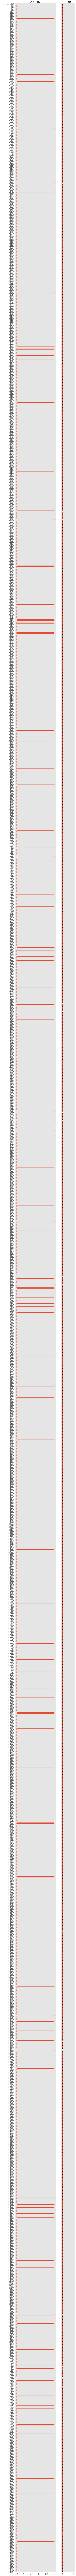

In [260]:
az.plot_forest(trace, var_names=['is_extreme'], combined=True, r_hat=True)
plt.show()

### Posterior distributions and sampled values of each parameter

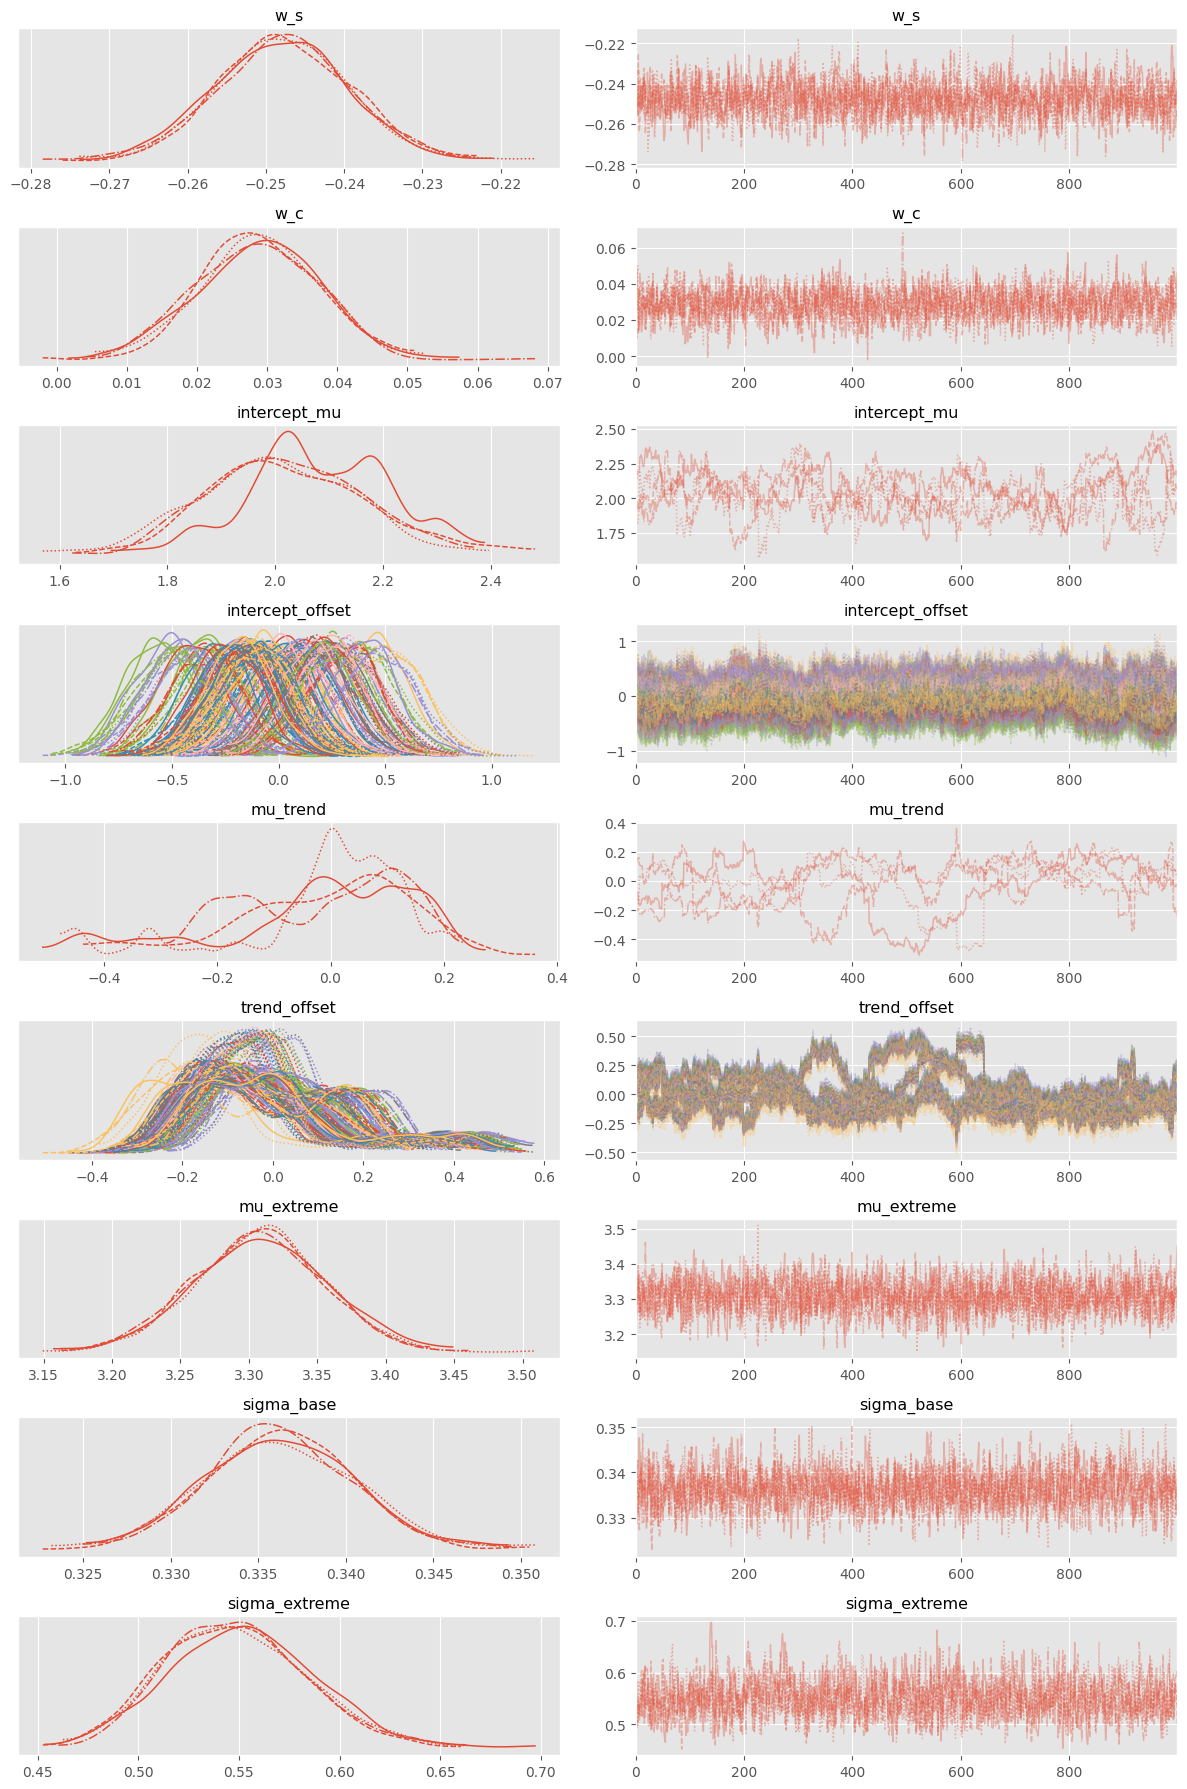

In [192]:
az.plot_trace(trace, compact=True)
plt.tight_layout()

This figure displays the posterior distributions of parameters (left) and the corresponding autocorrelation plots (right) for parameters **c, alpha, w_s and w_c.** The posterior distributions illustrate the range of parameter values after sampling, with **different colors representing the different counties.** The autocorrelation plots on the right assess the efficiency and convergence of the MCMC sampling, where lower autocorrelation indicates more efficient sampling. **Different dashed line styles represent the different chains** used during sampling, helping to verify that the chains have converged to a similar distribution.

### Generating predictions based on posterior distribution of the model

In [261]:
posterior_predictive = pm.sample_posterior_predictive(trace, model=model)

# Extract posterior predictive samples
ppc_samples = posterior_predictive.posterior_predictive['Y'].values

Sampling: [Y]


Output()

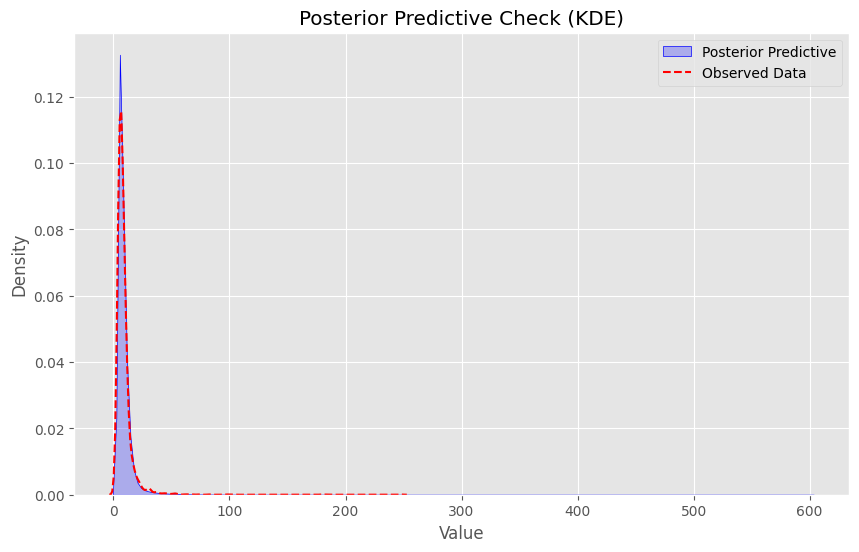

In [262]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ppc_samples.flatten(), label='Posterior Predictive', color='blue', fill=True)
sns.kdeplot(monthly_avg['Monthly Avg PM2.5'], label='Observed Data', color='red', linestyle='--')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior Predictive Check (KDE)')
plt.legend()
plt.show()

**Figure 4:** This figure visually compares the distribution of model-predicted values (purple shade) with the actual observed data (dashed red line). The comparison is based on predictions derived from the model's posterior distribution, checked against the observed data to assess consistency. The misalignment between the two distributions at their peaks and tails suggests that the model may have difficulty accurately predicting certain data points, i.e. outliers.

### Compute predictions

We will compute the mean of the posterior predictive samples to obtain predictions and calculate percentiles from these samples to represent prediction uncertainty. Although the Bayesian approach also allows for determining credible intervals for model parameters to assess their uncertainty, I will focus on using percentiles of the predictions for easier data visualization.

In [263]:
predicted_means = np.mean(np.mean(ppc_samples, axis=0), axis=0) #average over chains and samples
monthly_avg["predicted_means"] = predicted_means
monthly_avg["is_extreme"] = trace.posterior["is_extreme"].mean(dim=["chain", "draw"]).values

lower_bound = np.percentile(np.mean(ppc_samples, axis=0), 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(np.mean(ppc_samples, axis=0), 97.5, axis=0)  # 97.5th percentile

monthly_avg["lower_bound"] = lower_bound
monthly_avg["upper_bound"] = upper_bound

### Calculate r2

In [264]:
r2_scores = {}

for region_id in monthly_avg['county_id'].unique():
    group = monthly_avg[monthly_avg['county_id'] == region_id]
    y_obs = group['Monthly Avg PM2.5'].values
    y_pred = group['predicted_means'].values
    county_name = group['County'].iloc[0]
    r2_scores[county_name] = r2_score(y_obs, y_pred)

for county_name, r2 in r2_scores.items():
    print(f'R-squared for {county_name}: {r2}')

R-squared for Alameda: 0.6977074073791394
R-squared for Butte: 0.8106246747252703
R-squared for Calaveras: 0.8707817127360705
R-squared for Colusa: 0.8139489590936597
R-squared for Contra Costa: 0.6391781182385979
R-squared for Del Norte: 0.6027142035097459
R-squared for Fresno: 0.7288152368027114
R-squared for Glenn: 0.7835787387389608
R-squared for Imperial: -0.0914888812795438
R-squared for Inyo: 0.7112764761688621
R-squared for Kern: 0.6542035424176214
R-squared for Kings: 0.5542897374363223
R-squared for Los Angeles: 0.285315369377126
R-squared for Madera: 0.7080231868514271
R-squared for Marin: 0.5587586038373823
R-squared for Mariposa: 0.49792187925675635
R-squared for Mendocino: 0.7062483695836391
R-squared for Merced: 0.706849714844708
R-squared for Mono: 0.295122203874048
R-squared for Monterey: 0.5829036197843342
R-squared for Nevada: 0.7961383060013284
R-squared for Orange: 0.42165013417108277
R-squared for Placer: 0.8436044877283313
R-squared for Plumas: 0.5497888818252182

### Observed vs Predicted plot for each county

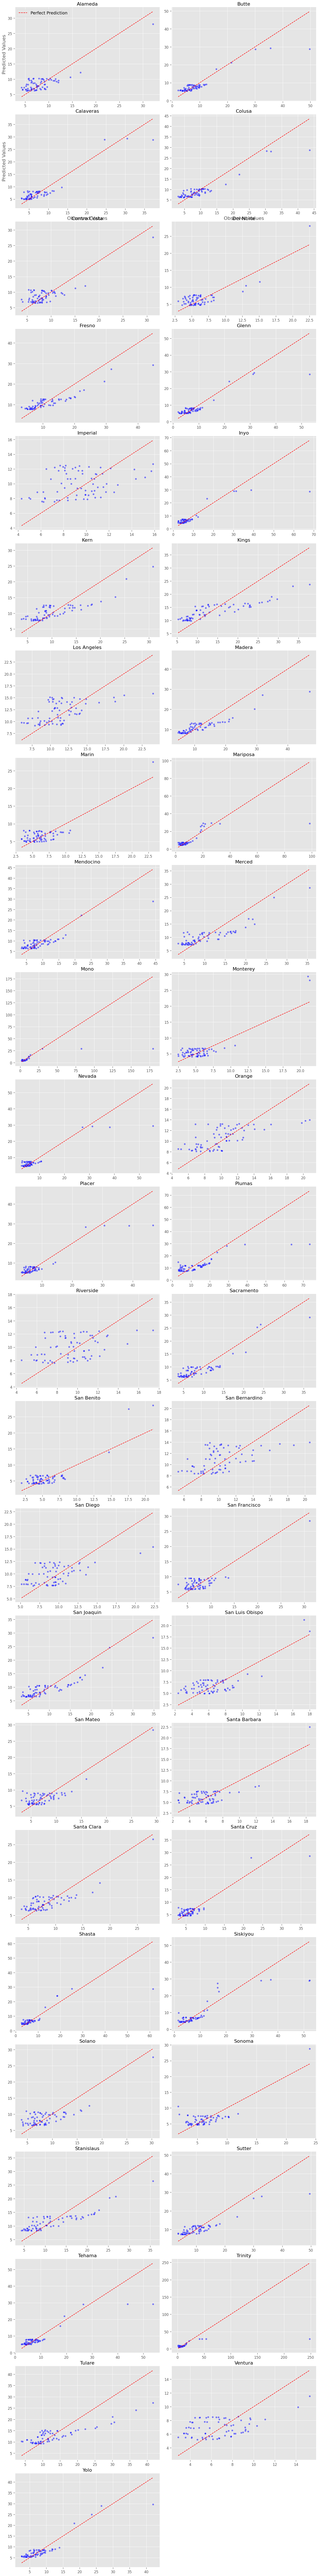

In [265]:
g = sns.FacetGrid(monthly_avg   , col='County', col_wrap=2, height=5, aspect=1.5, sharex=False, sharey=False)
g.map(sns.scatterplot, 'Monthly Avg PM2.5', 'predicted_means', alpha=0.5, color='blue')
g.map(sns.lineplot, 'Monthly Avg PM2.5', 'Monthly Avg PM2.5', color='red', linestyle='--', label='Perfect Prediction')

_ = [ax.set_title(title, fontsize=16) for ax, title in zip(g.axes.flat, g.col_names)]

for i, ax in enumerate(g.axes.flat):
    x_label = "Observed Values" if i == 2 or i == 3 else ''
    y_label = "Predicted Values" if i == 0 or i == 2 else ''
    
    ax.set_xlabel(x_label, fontsize=16 if x_label else None)
    ax.set_ylabel(y_label, fontsize=16 if y_label else None)
    
    ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)

# Add legend to the first subplot with non-empty legend handles
next((ax.legend(*ax.get_legend_handles_labels(), fontsize=14, loc='upper left', bbox_to_anchor=(0, 1))
      for ax in g.axes.flat if ax.get_legend_handles_labels()[0]), None)

**Figure 5:** This plot compares the observed data (x-axis) with the predicted values (y-axis) generated by the model for 4 regions. The diagonal red dashed line represents the line of perfect prediction. Points close to this line indicate better predictions (as in Region 1, and some points in Region 2 and 3), while scattered points (as in Region 4, and some point in Region 2 and 3) indicate more significant discrepancies between the model’s predictions and the observed data.

### Predictions for each county

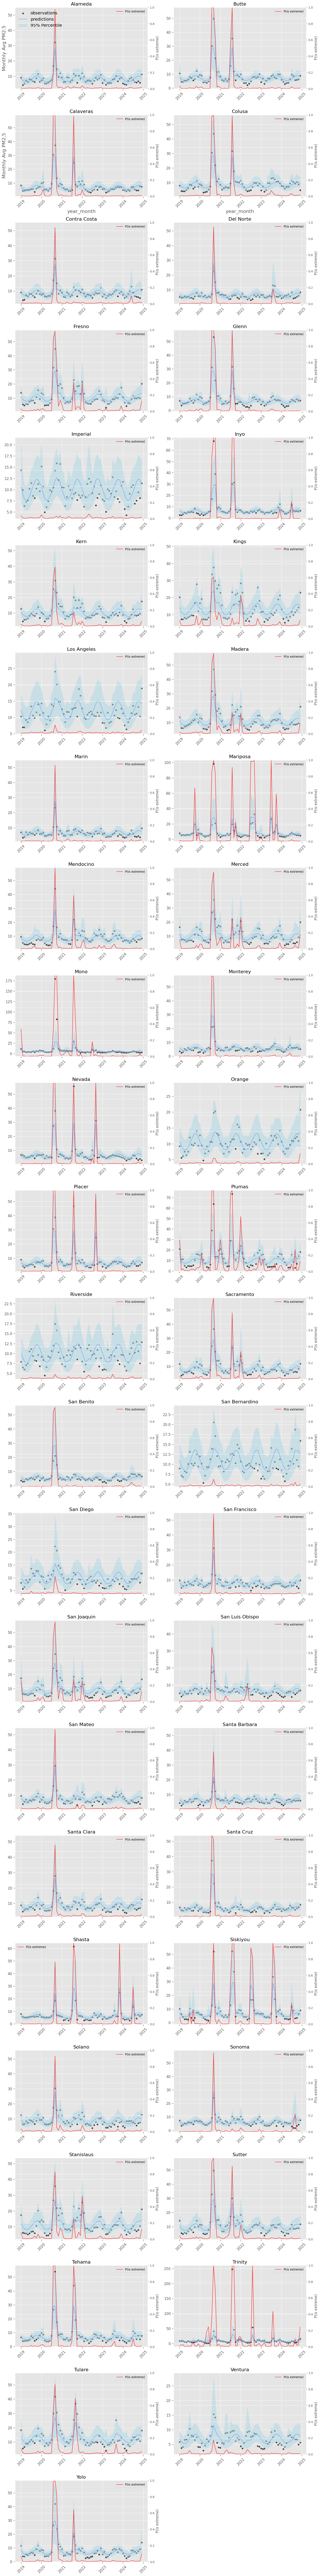

In [266]:
g = sns.FacetGrid(monthly_avg, col='County', col_wrap=2, height=5, aspect=1.5, sharex=False, sharey=False)
g.map(sns.scatterplot, 'year_month', 'Monthly Avg PM2.5', label = 'observations', color='black', alpha=0.7)
g.map(sns.lineplot, 'year_month', 'predicted_means', label='predictions', color='cornflowerblue', alpha=0.7)

# g.map(sns.lineplot, 'year_month', 'is_extreme', label='is extreme?', color='red', alpha=0.7)

fill_patch = patches.Patch(color='lightblue', alpha=0.5, label='95% Percentile')
for ax, (region, subset) in zip(g.axes.flat, monthly_avg.groupby('County')):
    ax.fill_between(subset['year_month'], 
                    subset['lower_bound'],
                    subset['upper_bound'], 
                    color='lightblue', alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.set_ylabel('P(is extreme)', fontsize=12)
    ax2.set_ylim(0, 1)
    sns.lineplot(data=subset, x='year_month', y='is_extreme', ax=ax2, color='red', alpha=0.7, label='P(is extreme)')

_ = [ax.set_title(title, fontsize=16) for ax, title in zip(g.axes.flat, g.col_names)]

for i, ax in enumerate(g.axes.flat):
    x_label = 'year_month' if i == 2 or i == 3 else ''
    y_label = 'Monthly Avg PM2.5' if i == 0 or i == 2 else ''
    
    ax.set_xlabel(x_label, fontsize=16 if x_label else None)
    ax.set_ylabel(y_label, fontsize=16 if y_label else None)
    
    ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
    ax.tick_params(axis='x', rotation=45)
    
first_ax = g.axes.flat[0]  # Access the first subplot
handles, labels = first_ax.get_legend_handles_labels()
handles.append(fill_patch)  # Add the fill color patch
labels.append('95% Percentile')  # Add label for the fill color
first_ax.legend(handles, labels, fontsize=14, loc='upper left', bbox_to_anchor=(0, 1))
    
plt.tight_layout()

**Figure 6:** Observed data (black dots) and predictions (blue lines) are shown for four regions. The shaded areas represent the 5%-95% percentiles of the predictions, indicating the uncertainty range. The model fits Region 1 the best. For Regions 2 and 3, overestimation of data points tends to occur as the effects of seasonality decrease. The model also performs well for Region 4. Although it occasionally overestimates data points, the discrepancies are relatively minor.

## Model 2: No hierarchy

## Model 3: County-hierarchy

# Model comparison

In [419]:
#az.compare({"model": trace, 
#                   "model_no_hierarchy": trace_no_hierarchy, 
#                   "model_with_additional_hierarchy": trace_with_additional_hierarchy}, 
#           ic='loo', method = 'BB-pseudo-BMA')

### Exploration of khat values

In [420]:
#loo_result = az.loo(trace_with_additional_hierarchy, pointwise=True)
#az.plot_khat(loo_result, figsize=(10, 6))

In [421]:
## Extract Pareto k values
#pareto_k = loo_result.pareto_k.values
#
## Find problematic observations
#problematic_indices = np.where(pareto_k > 0.7)[0]
#print(f"Problematic observations (Pareto k > 0.7): {problematic_indices}")

## Make predictions for unseen data points

### Prepare unseen data

In [422]:
#filtered_df = monthly_demand_regions[monthly_demand_regions['region'].isin(["region_1", "region_2", "region_3", "region_4"])]
#filtered_df = filtered_df[['region', 'first_date']].drop_duplicates()

In [423]:
#dates = ['2024-01-01', '2024-02-01', '2024-03-01']
#regions = ['region_1', 'region_2', 'region_3', 'region_4']
#region_ids = {'region_1': 0, 'region_2': 1, 'region_3': 2, 'region_4': 3}
#
#unseen_data = pd.DataFrame([
#    {'region': region, 'deliver_year_month': date, 
#     'first_date': filtered_df.loc[filtered_df['region'] == region, 'first_date'].values[0], 
#     'region_id': region_ids[region]}
#    for region in regions
#    for date in dates
#])
#
#unseen_data['deliver_year_month'] = pd.to_datetime(unseen_data['deliver_year_month'])
#unseen_data['first_date'] = pd.to_datetime(unseen_data['first_date'])

In [424]:
#unseen_data["time_passed_total"] = (
#    unseen_data['deliver_year_month'].apply(datetime.datetime.toordinal)
#    -unseen_data['first_date'].apply(datetime.datetime.toordinal)
#)/365.0

In [425]:
#unseen_data

### Run a prediction model on unseen data

In [426]:
#with pm.Model() as prediction_model:
#    alpha = pm.HalfCauchy("alpha", beta=2)
#
#    sine_function = pm.math.sin(2 * np.pi * (unseen_data["time_passed_total"] % 1))
#    cosine_function = pm.math.cos(2 * np.pi * (unseen_data["time_passed_total"] % 1))
#
#    w_s = pm.Uniform("w_s", -1, 1)
#    w_c = pm.Uniform("w_c", -1, 1)
#
#    seasonality = 1 + sine_function * w_s + cosine_function * w_c
#
#    a = pm.Cauchy("a", alpha=0, beta=2, shape=(4,))
#    b = pm.Cauchy("b", alpha=0, beta=2, shape=(4,))
#    c = pm.Cauchy("c", alpha=0, beta=2, shape=(4,))
#
#    trend = pm.math.exp(
#        a[unseen_data["region_id"]] * unseen_data["time_passed_total"]**2 +
#        b[unseen_data["region_id"]] * unseen_data["time_passed_total"] +
#        c[unseen_data["region_id"]])
#
#    mu = seasonality * trend
#
#    Y_pred = pm.NegativeBinomial("Y_pred", mu=mu, alpha=alpha)
#
#    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["Y_pred"]) # trace from the trained model
#

In [427]:
#unseen_predictions = posterior_predictive.posterior_predictive["Y_pred"]
#
## Compute the mean of posterior predictive samples as predictions
#unseen_predicted_means = np.mean(np.mean(unseen_predictions, axis=0), axis=0) #average over chains and samples
#unseen_data["predicted_means"] = unseen_predicted_means
#
## compute percentiles
#unseen_lower_bound = np.percentile(np.mean(unseen_predictions, axis=0), 2.5, axis=0)  # 2.5th percentile
#unseen_upper_bound = np.percentile(np.mean(unseen_predictions, axis=0), 97.5, axis=0)  # 97.5th percentile
#
#unseen_data["lower_bound"] = unseen_lower_bound
#unseen_data["upper_bound"] = unseen_upper_bound

### Figure 7: Predictions for region on unseen data


In [428]:
#g = sns.FacetGrid(monthly_demand_regions, col='region', col_wrap=2, height=5, aspect=1.5, sharex=False, sharey=False)
#
## Plot the original data
#g.map(sns.scatterplot, 'deliver_year_month', 'order_count', label='observations', color='black', alpha=0.7)
#g.map(sns.lineplot, 'deliver_year_month', 'predicted_means', label='predictions', color='cornflowerblue', alpha=0.7)
#
## Plot predictions and intervals for unseen data
#for ax, (region, subset) in zip(g.axes.flat, monthly_demand_regions.groupby('region')):
#    pred_subset = unseen_data[unseen_data['region'] == region]
#    
#    if not subset.empty and not pred_subset.empty:
#        last_obs_point = subset.iloc[-1]
#        first_unseen_point = pred_subset.iloc[0]
#
#        # Connect the predicted means
#        ax.plot([last_obs_point['deliver_year_month'], first_unseen_point['deliver_year_month']],
#                [last_obs_point['predicted_means'], first_unseen_point['predicted_means']],
#                color='grey', linestyle='--', alpha=0.5)
#
#        # Connect the lower bounds
#        ax.plot([last_obs_point['deliver_year_month'], first_unseen_point['deliver_year_month']],
#                [last_obs_point['lower_bound'], first_unseen_point['lower_bound']],
#                color='grey', linestyle='--', alpha=0.5)
#
#        # Connect the upper bounds
#        ax.plot([last_obs_point['deliver_year_month'], first_unseen_point['deliver_year_month']],
#                [last_obs_point['upper_bound'], first_unseen_point['upper_bound']],
#                color='grey', linestyle='--', alpha=0.5)
#    
#    ax.plot(pred_subset['deliver_year_month'], pred_subset['predicted_means'], 
#            label='predictions (unseen data)', color='red', alpha=0.7)
#
#    ax.fill_between(pred_subset['deliver_year_month'], 
#                    pred_subset['lower_bound'],
#                    pred_subset['upper_bound'], 
#                    color='orange', alpha=0.5, label='95% Percentile (unseen Data)')
#
#for ax, (region, subset) in zip(g.axes.flat, monthly_demand_regions.groupby('region')):
#    ax.fill_between(subset['deliver_year_month'], 
#                    subset['lower_bound'],
#                    subset['upper_bound'], 
#                    color='lightblue', alpha=0.5, label='95% Percentile')
#
#_ = [ax.set_title(title, fontsize=16) for ax, title in zip(g.axes.flat, g.col_names)]
#
#for i, ax in enumerate(g.axes.flat):
#    x_label = "Date" if i == 2 or i == 3 else ''
#    y_label = "Demand" if i == 0 or i == 2 else ''
#    
#    ax.set_xlabel(x_label, fontsize=16 if x_label else None)
#    ax.set_ylabel(y_label, fontsize=16 if y_label else None)
#    
#    ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
#    ax.tick_params(axis='x', rotation=45)
#    
#first_ax = g.axes.flat[0]
#handles, labels = first_ax.get_legend_handles_labels()
#
#fill_patch_blue = patches.Patch(color='lightblue', alpha=0.5, label='95% Percentile')
#fill_patch_orange = patches.Patch(color='orange', alpha=0.5, label='95% Percentile (unseen Data)')
#
#handles.append(fill_patch_blue)
#handles.append(fill_patch_orange)
#first_ax.legend(handles, labels, fontsize=14, loc='upper left', bbox_to_anchor=(0, 1))
#
#plt.tight_layout()

**Figure 7:** Observed data (black dots), predictions based on observed data (blue lines), and predictions on unseen data (red lines) are shown for four regions. The shaded blue areas represent the 5%-95% percentiles of the predictions on observed data, while the shaded orange areas indicate the same for predictions on unseen data. Dashed grey lines connect the last observed points to the first unseen points, addressing the gap between the two periods due to the lack of overlap. This plot is used to assess how well the model generalizes from observed to unseen data. The model's predictions on unseen data for the four regions closely follow the predictions based on observed data, suggesting that the model generalizes well across different datasets.